# Data Prep

## Parse the json

In [1]:
import json
with open('../solve/data/Json/graph_out.json', 'r') as f:
    adjacency_list = json.load(f)

## Convert to `edge_index` for PyTorch

In [2]:
import torch
from torch_geometric.data import Data

# Map node names (strings) to indices (integers)
node_mapping = {node: idx for idx, node in enumerate(adjacency_list.keys())}

# Create edge indices with numerical node IDs
edges = []
for node, neighbors in adjacency_list.items():
    for neighbor in neighbors:
        edges.append((node_mapping[node], node_mapping[neighbor]))

# Convert to tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_index


tensor([[   0,    0,    2,  ..., 4907, 4908, 4909],
        [3154, 4542,  923,  ..., 4909, 2976, 2978]])

## Construct default `node_features` matrix

In [3]:
num_nodes = len(adjacency_list)
node_features = torch.eye(num_nodes)

## Extract labels `y`

In [4]:
# Extract labels for each node based on the subject
node_labels = {}
for node in adjacency_list.keys():
    # Extract the subject (second component after the first dot)
    subject = node.split('.')[1] if '.' in node else "Unknown"
    node_labels[node] = subject

label_mapping = {label: idx for idx, label in enumerate(set(node_labels.values()))}
y = [label_mapping[label] for label in node_labels.values()]
y = torch.tensor(y, dtype=torch.long)

## Import to torch_geometric Data

In [5]:
data = Data(x=node_features, edge_index=edge_index, y=y)

## Do a train-val-test split

In [6]:
# Define the number of nodes
num_nodes = data.num_nodes

# Train-test split proportions
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Randomly shuffle node indices
indices = torch.randperm(num_nodes)

# Split indices
train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

# Create masks
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

# Build GCN and train it

Epoch:   0, Loss: 3.2547, Accuracy:   4.79%; Val Accuracy:   4.48%; Test Accuracy:   5.09%
Epoch:  10, Loss: 1.0952, Accuracy:  79.71%; Val Accuracy:  67.21%; Test Accuracy:  66.80%
Epoch:  20, Loss: 0.1689, Accuracy:  97.53%; Val Accuracy:  76.58%; Test Accuracy:  74.95%
Epoch:  30, Loss: 0.0231, Accuracy:  99.87%; Val Accuracy:  79.63%; Test Accuracy:  76.58%
Epoch:  40, Loss: 0.0045, Accuracy:  99.95%; Val Accuracy:  79.23%; Test Accuracy:  75.36%
Epoch:  50, Loss: 0.0022, Accuracy:  99.97%; Val Accuracy:  79.02%; Test Accuracy:  75.97%
Epoch:  60, Loss: 0.0016, Accuracy:  99.97%; Val Accuracy:  79.02%; Test Accuracy:  75.97%
Epoch:  70, Loss: 0.0012, Accuracy:  99.97%; Val Accuracy:  79.02%; Test Accuracy:  76.17%
Epoch:  80, Loss: 0.0010, Accuracy: 100.00%; Val Accuracy:  78.82%; Test Accuracy:  75.97%
Epoch:  90, Loss: 0.0007, Accuracy: 100.00%; Val Accuracy:  78.62%; Test Accuracy:  75.97%


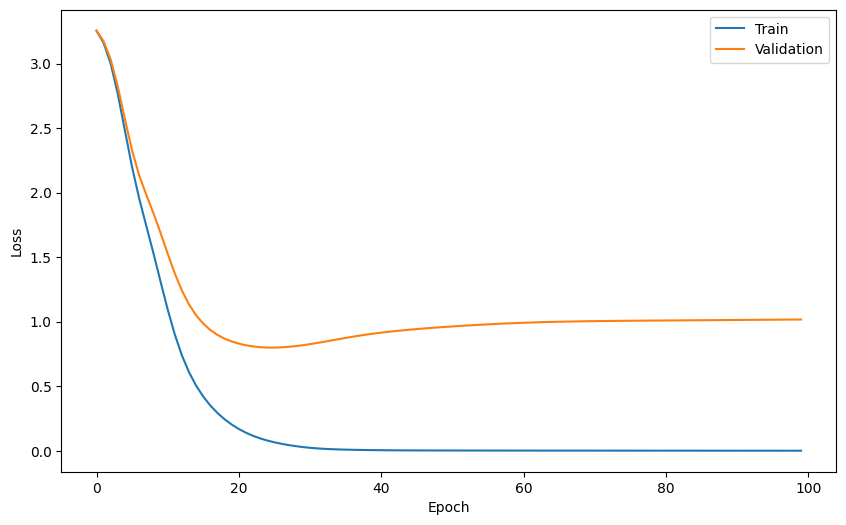

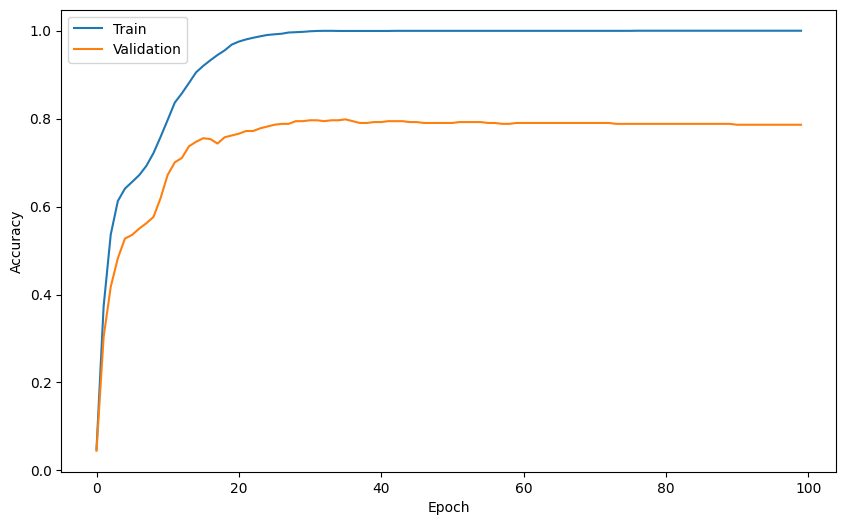

In [ ]:
# Build a one-layer GCN
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels = 16):
        super().__init__()
        self.gcn = GCNConv(data.num_features, hidden_channels)
        self.out = Linear(hidden_channels, len(label_mapping))

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

import matplotlib.pyplot as plt

x = data.x
train_y = data.y[data.train_mask]
val_y = data.y[data.val_mask]

learning_rate = 0.01
epochs = 100
hidden_channels = 512
model = GCN(hidden_channels)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# the training loop
accs = []
losses = []
val_accs = []
val_losses = []
test_accs = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    h, z = model(x, edge_index)
    train_h, train_z = h[data.train_mask], z[data.train_mask]
    loss = criterion(train_z, train_y)
    loss.backward()
    optimizer.step()

    acc = accuracy(train_z.argmax(dim=1), train_y)
    accs.append(acc)
    losses.append(loss.detach().numpy())

    model.eval()
    with torch.no_grad():
        val_h, val_z = h[data.val_mask], z[data.val_mask]
        val_acc = accuracy(val_z.argmax(dim=1), val_y)
        val_loss = criterion(val_z, val_y)
        val_accs.append(val_acc)
        val_losses.append(val_loss.detach().numpy())
        test_acc = accuracy(z[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        test_accs.append(test_acc)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:>3}, Loss: {loss:.4f}, Accuracy: {acc*100:>6.2f}%; Val Accuracy: {val_acc*100:>6.2f}%; Test Accuracy: {test_acc*100:>6.2f}%")
    

plt.figure(figsize=(10, 6))
plt.plot(losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("fig/loss.pdf", dpi = 300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("fig/acc.pdf", dpi = 300)
plt.show()

Epoch:   0, Loss: 3.2490, Accuracy:   4.18%; Val Accuracy:   5.50%
Epoch:  10, Loss: 1.9851, Accuracy:  54.05%; Val Accuracy:  49.29%
Epoch:  20, Loss: 0.8764, Accuracy:  75.03%; Val Accuracy:  67.01%
Epoch:  30, Loss: 0.3803, Accuracy:  89.89%; Val Accuracy:  74.34%
Epoch:  40, Loss: 0.1098, Accuracy:  97.40%; Val Accuracy:  76.17%
Epoch:  50, Loss: 0.0298, Accuracy:  99.69%; Val Accuracy:  76.78%
Epoch:  60, Loss: 0.0114, Accuracy:  99.90%; Val Accuracy:  75.97%
Epoch:  70, Loss: 0.0057, Accuracy:  99.95%; Val Accuracy:  75.76%
Epoch:  80, Loss: 0.0036, Accuracy: 100.00%; Val Accuracy:  75.76%
Epoch:  90, Loss: 0.0025, Accuracy: 100.00%; Val Accuracy:  75.56%


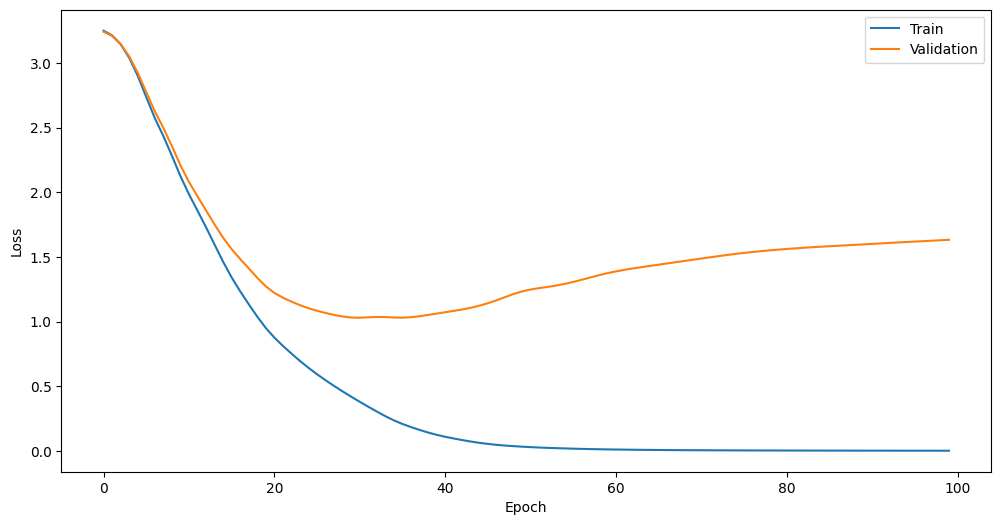

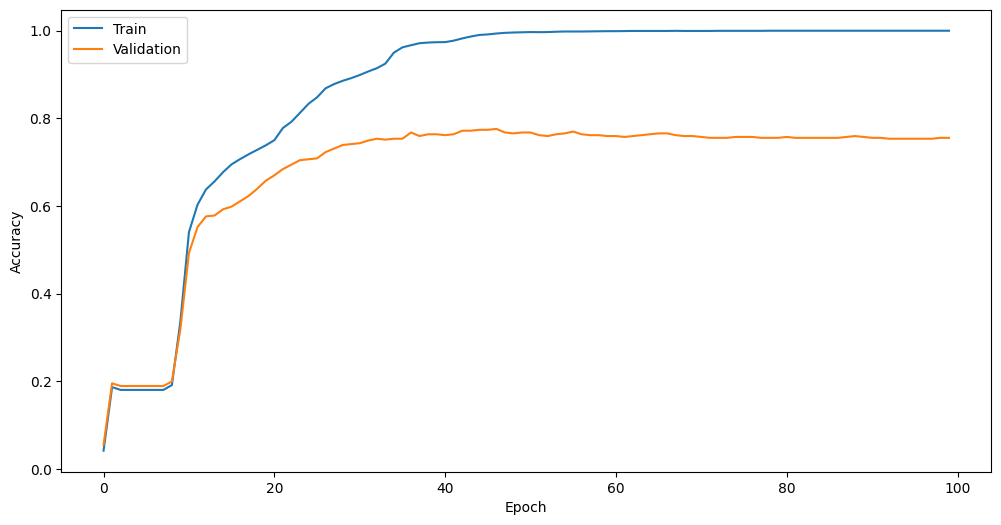

In [39]:
# Build a two-layer GCN
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels1 = 16, hidden_channels2 = 16):
        super().__init__()
        self.gcn1 = GCNConv(data.num_features, hidden_channels1)
        self.gcn2 = GCNConv(hidden_channels1, hidden_channels2)
        self.out = Linear(hidden_channels2, len(label_mapping))

    def forward(self, x, edge_index):
        h1 = self.gcn1(x, edge_index).relu()
        h = self.gcn2(h1, edge_index).relu()
        z = self.out(h)
        return h, z
    
import matplotlib.pyplot as plt

x = data.x
train_y = data.y[data.train_mask]
val_y = data.y[data.val_mask]

learning_rate = 0.01
epochs = 100
hidden_channels1 = 512
hidden_channels2 = 16
model = GCN(hidden_channels1, hidden_channels2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# the training loop
accs = []
losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    h, z = model(x, edge_index)
    train_h, train_z = h[data.train_mask], z[data.train_mask]
    loss = criterion(train_z, train_y)
    loss.backward()
    optimizer.step()

    acc = accuracy(train_z.argmax(dim=1), train_y)
    accs.append(acc)
    losses.append(loss.detach().numpy())

    model.eval()
    with torch.no_grad():
        val_h, val_z = h[data.val_mask], z[data.val_mask]
        val_acc = accuracy(val_z.argmax(dim=1), val_y)
        val_loss = criterion(val_z, val_y)
        val_accs.append(val_acc)
        val_losses.append(val_loss.detach().numpy())

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:>3}, Loss: {loss:.4f}, Accuracy: {acc*100:>6.2f}%; Val Accuracy: {val_acc*100:>6.2f}%")
    

plt.figure(figsize=(12, 6))
plt.plot(losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("fig/loss.pdf", dpi = 300)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("fig/acc.pdf", dpi = 300)
plt.show()

In [43]:
# baseline model
import torch
from collections import Counter

def compute_baseline(edge_index, y, test_mask):
    # Number of nodes
    num_nodes = y.size(0)
    
    # Create adjacency list
    adjacency_list = {i: [] for i in range(num_nodes)}
    for src, dst in edge_index.t().tolist():
        adjacency_list[src].append(dst)
    
    # Predict labels for test nodes
    y_pred = torch.zeros_like(y)
    for node in range(num_nodes):
        if test_mask[node]:
            # Get labels of the node's neighbors
            neighbor_labels = [y[neighbor].item() for neighbor in adjacency_list[node]]
            
            if neighbor_labels:
                # Most common label among neighbors
                most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
                y_pred[node] = most_common_label
            else:
                # If no neighbors, fallback to a default label (e.g., 0)
                y_pred[node] = 0

    return y_pred

y_pred = compute_baseline(edge_index, y, data.test_mask)
# Calculate accuracy on the test set
correct = (y_pred[data.test_mask] == y[data.test_mask]).sum().item()
total = data.test_mask.sum().item()
accuracy = correct / total

print(f"Baseline Accuracy: {accuracy:.4f}")


Baseline Accuracy: 0.5601


In [ ]:
# Build a one-layer GCN
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels = 16):
        super().__init__()
        self.gcn = GCNConv(data.num_features, hidden_channels)
        self.out = Linear(hidden_channels, len(label_mapping))

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

import matplotlib.pyplot as plt

x = data.x
train_y = data.y[data.train_mask]
val_y = data.y[data.val_mask]

learning_rate = 0.01
epochs = 30
hidden_channels = 512
model = GCN(hidden_channels)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# the training loop
accs = []
losses = []
val_accs = []
val_losses = []
test_accs = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    h, z = model(x, edge_index)
    train_h, train_z = h[data.train_mask], z[data.train_mask]
    loss = criterion(train_z, train_y)
    loss.backward()
    optimizer.step()

    acc = accuracy(train_z.argmax(dim=1), train_y)
    accs.append(acc)
    losses.append(loss.detach().numpy())

    model.eval()
    with torch.no_grad():
        val_h, val_z = h[data.val_mask], z[data.val_mask]
        val_acc = accuracy(val_z.argmax(dim=1), val_y)
        val_loss = criterion(val_z, val_y)
        val_accs.append(val_acc)
        val_losses.append(val_loss.detach().numpy())
        test_acc = accuracy(z[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        test_accs.append(test_acc)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:>3}, Loss: {loss:.4f}, Accuracy: {acc*100:>6.2f}%; Val Accuracy: {val_acc*100:>6.2f}%; Test Accuracy: {test_acc*100:>6.2f}%")

Epoch:   0, Loss: 3.2701, Accuracy:   1.12%; Val Accuracy:   2.04%; Test Accuracy:   1.43%
Epoch:  10, Loss: 1.1069, Accuracy:  79.61%; Val Accuracy:  67.21%; Test Accuracy:  66.60%
Epoch:  20, Loss: 0.1722, Accuracy:  97.33%; Val Accuracy:  76.58%; Test Accuracy:  75.36%


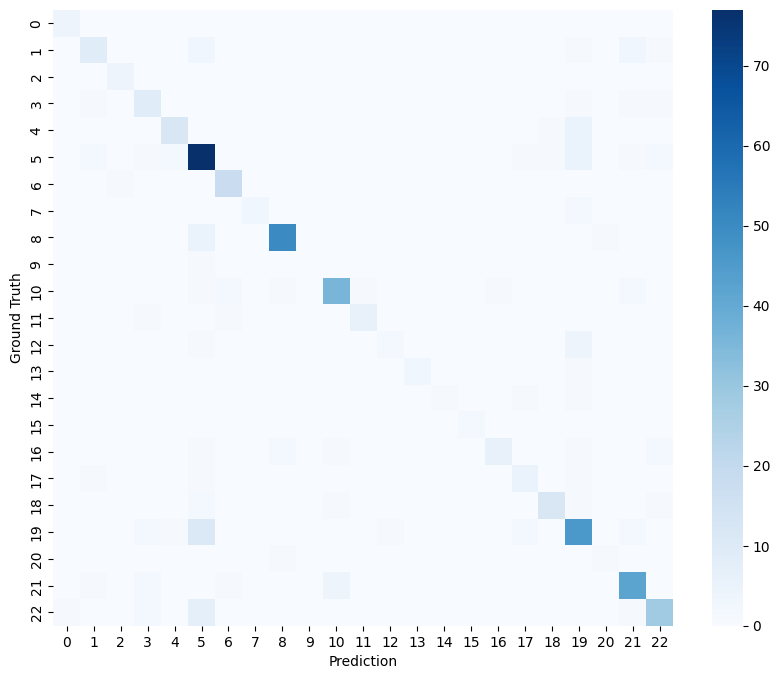

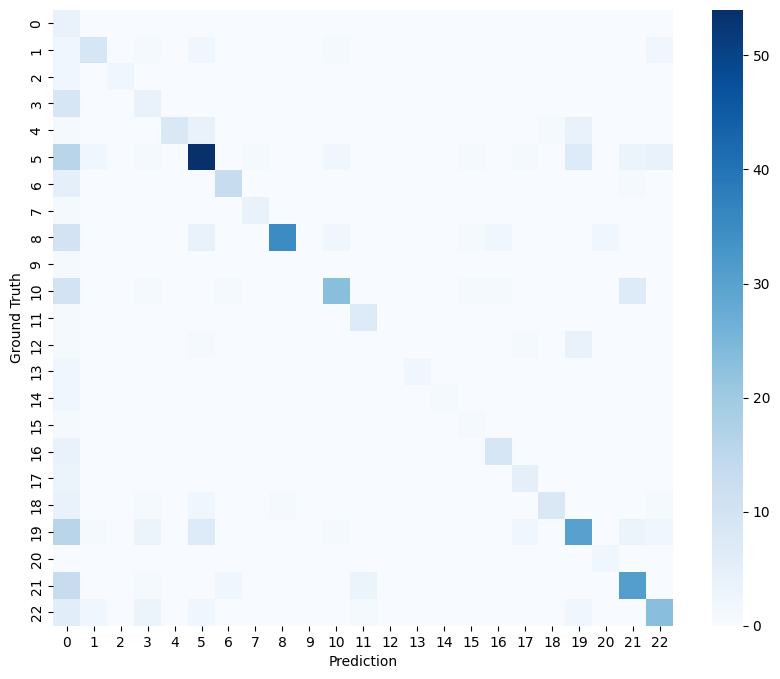

In [50]:
# get y_pred
y_pred_gnn = z.argmax(dim=1)

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(data.y[data.test_mask], y_pred_gnn[data.test_mask])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.savefig("fig/confusion_matrix_gnn.pdf", dpi = 300)
plt.show()


cm = confusion_matrix(data.y[data.test_mask], y_pred[data.test_mask])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, fmt="d", cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.savefig("fig/confusion_matrix_baseline.pdf", dpi = 300)
plt.show()

In [51]:
label_mapping

{'FieldTheory': 0,
 'Dynamics': 1,
 'LinearAlgebra': 2,
 'Probability': 3,
 'Computability': 4,
 'NumberTheory': 5,
 'Order': 6,
 'Algebra': 7,
 'MeasureTheory': 8,
 'ModelTheory': 9,
 'CategoryTheory': 10,
 'RepresentationTheory': 11,
 'Topology': 12,
 'Geometry': 13,
 'Logic': 14,
 'SetTheory': 15,
 'Control': 16,
 'Condensed': 17,
 'AlgebraicGeometry': 18,
 'Combinatorics': 19,
 'InformationTheory': 20,
 'GroupTheory': 21,
 'Data': 22,
 'AlgebraicTopology': 23,
 'Analysis': 24,
 'RingTheory': 25}